In [1]:
import numpy as np
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tsxv.splitTrain import split_train, split_train_variableInput
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from backtesting import *
from dask.distributed import Client
client = Client(processes=False)
client

Client Scheduler: inproc://192.168.1.5/7164/1 Dashboard: http://192.168.1.5:8787/status,Cluster Workers: 1 Cores: 12 Memory: 15.37 GiB


In [100]:
lss = [(0, (1, 10)), '--', '-.', (0, (1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))]
flag_ls = True

In [109]:
def summary_table(expected_returns, sharpe, sortino, index_names, group_col, alpha=0.05, n_digits=2):
    alpha_2 = alpha / 2
    funcs = [
        'mean',
        lambda x: np.quantile(x, alpha_2), 
        lambda x: np.quantile(x, 1-alpha_2),
    ]
    func_names = ['mean', 'ci_low', 'ci_up']
    
    df_returns = expected_returns
    df_sharpe = sharpe
    df_sortino = sortino
    
    agg_returns_df = df_returns.groupby(group_col)['value'].agg(funcs)
    agg_returns_df = (agg_returns_df * 100).round(n_digits).astype(str) + '\%'
    agg_returns_df.columns = func_names
    p_neg_returns = df_returns.groupby(group_col)['value'].apply(lambda x: (x < 0).mean()).round(n_digits)
    agg_sharpe_df = df_sharpe.groupby(group_col)['value'].agg(funcs).round(n_digits).astype(str)
    agg_sharpe_df.columns = func_names
    agg_sortino_df = df_sortino.groupby(group_col)['value'].agg(funcs).round(n_digits).astype(str)
    agg_sortino_df.columns = func_names
    
    summary = pd.DataFrame({
        'Excess Returns': agg_returns_df['mean'],
        'Sharpe Ratio': agg_sharpe_df['mean'],
        'Sortino Ratio': agg_sortino_df['mean'],
        # r'$\mathbb{P}(\mathbb{E}[R] < 0)$': p_neg_returns,
        '\ ': '\\\\ ',
        '\  ': ' (' + agg_returns_df['ci_low'] + '-' + agg_returns_df['ci_up'] + ')',
        '\   ': ' (' + agg_sharpe_df['ci_low'] + '-' + agg_sharpe_df['ci_up'] + ')',
        '\    ': ' (' + agg_sortino_df['ci_low'] + '-' + agg_sortino_df['ci_up'] + ')',
        # '\     ': '&'
    })
    summary.index.names = index_names
    # summary = summary.reset_index()
    
    print(summary.to_latex(bold_rows=True,
                       caption='This is the caption',
                       escape=False,
                       # column_format='lllllrlll'
                      ))
    
    return summary

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Load Data

In [3]:
volumes = np.log10(pd.read_csv("data/volumes_CRSP.csv", index_col='datadate'))

In [4]:
prices = pd.read_csv("data/prices_CRSP.csv")
prices['datadate'] = prices['datadate'].astype(str).str[:-2]
prices = prices.rename(columns={'datadate': 'year_month'}).set_index('year_month')

monthly_log_returns = np.log2(prices).diff().iloc[1:]#.shift(-1).iloc[:-1]
monthly_log_returns

,1010,1034,1040,1054,1062,1075,1076,1078,1119,1128,...,264647,264686,264708,266214,268208,269005,277812,287462,287882,294524
year_month,,,,,,,,,,,,,,,,,,,,,
196207,0.193745,NaN,-0.083416,NaN,NaN,0.120854,NaN,-0.005714,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196208,-0.007717,NaN,0.050626,NaN,NaN,0.038135,NaN,-0.119299,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196209,-0.080441,NaN,-0.157541,NaN,NaN,-0.038135,NaN,0.054908,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196210,0.099233,NaN,-0.105493,NaN,NaN,-0.072374,NaN,0.103919,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196211,0.099986,NaN,0.212408,NaN,NaN,0.178148,NaN,0.107313,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202206,NaN,NaN,NaN,NaN,-0.318186,-0.086720,-0.823008,-0.112481,-0.114754,NaN,...,-0.218711,-0.138488,NaN,-0.261180,-0.143390,NaN,-0.116598,0.017947,-0.637999,-0.385499
202207,NaN,NaN,NaN,NaN,0.044543,0.006889,0.158807,0.002521,0.117357,NaN,...,0.093622,0.122345,NaN,0.212669,0.111950,NaN,-0.419903,-0.017947,-0.016030,0.027126
202208,NaN,NaN,NaN,NaN,-0.113016,0.036452,0.009368,-0.084475,-0.050286,NaN,...,-0.040510,-0.047917,NaN,-0.045949,0.009680,NaN,-0.192645,0.019927,-0.058950,-0.102638


### Load Factors

In [56]:
factors = pd.read_csv("data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=2)
factors = factors[factors['Date'].astype(str).str.strip().str.len() == 6]
factors = factors.set_index('Date')
factors.columns += '_factor'
factors = factors.astype(np.float64)
factors

,Mkt-RF_factor,SMB_factor,HML_factor,RMW_factor,CMA_factor,RF_factor
Date,,,,,,
196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27
196308,5.07,-0.80,1.80,0.36,-0.35,0.25
196309,-1.57,-0.52,0.13,-0.71,0.29,0.27
196310,2.53,-1.39,-0.10,2.80,-2.01,0.29
196311,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...
202205,-0.34,-0.06,8.41,1.44,3.98,0.03
202206,-8.43,1.30,-5.97,1.85,-4.70,0.06
202207,9.57,1.88,-4.10,0.68,-6.94,0.08


In [57]:
returns_factors_merged = monthly_log_returns.merge(factors, right_index=True, left_index=True, suffixes=['', '_factor'])
returns_factors_merged

,1010,1034,1040,1054,1062,1075,1076,1078,1119,1128,...,277812,287462,287882,294524,Mkt-RF_factor,SMB_factor,HML_factor,RMW_factor,CMA_factor,RF_factor
196307,-0.068842,NaN,-0.205810,NaN,NaN,0.023847,NaN,0.200299,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.39,-0.41,-0.97,0.68,-1.18,0.27
196308,0.141354,NaN,0.065434,NaN,NaN,0.130175,NaN,0.145978,NaN,NaN,...,NaN,NaN,NaN,NaN,5.07,-0.80,1.80,0.36,-0.35,0.25
196309,-1.102568,NaN,-0.114742,NaN,NaN,-0.043881,NaN,-0.032105,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.57,-0.52,0.13,-0.71,0.29,0.27
196310,0.080909,NaN,-0.020043,NaN,NaN,-0.080158,NaN,-0.087401,NaN,NaN,...,NaN,NaN,NaN,NaN,2.53,-1.39,-0.10,2.80,-2.01,0.29
196311,0.309237,NaN,0.020043,NaN,NaN,0.040406,NaN,0.067263,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202205,NaN,NaN,NaN,NaN,-0.168785,0.125109,0.141116,0.049477,-0.017268,NaN,...,0.263483,-0.403454,0.058360,0.107722,-0.34,-0.06,8.41,1.44,3.98,0.03
202206,NaN,NaN,NaN,NaN,-0.318186,-0.086720,-0.823008,-0.112481,-0.114754,NaN,...,-0.116598,0.017947,-0.637999,-0.385499,-8.43,1.30,-5.97,1.85,-4.70,0.06
202207,NaN,NaN,NaN,NaN,0.044543,0.006889,0.158807,0.002521,0.117357,NaN,...,-0.419903,-0.017947,-0.016030,0.027126,9.57,1.88,-4.10,0.68,-6.94,0.08
202208,NaN,NaN,NaN,NaN,-0.113016,0.036452,0.009368,-0.084475,-0.050286,NaN,...,-0.192645,0.019927,-0.058950,-0.102638,-3.78,1.51,0.31,-4.80,1.31,0.19


In [58]:
def compute_trading_masks_from_idx(merged_df, factors_columns, idx_tuple,
                                   residuals_method_name, spreads_method, trading_method):
    x_idx, y_idx = idx_tuple
    returns_factors_merged_split_train = merged_df.loc[x_idx]
    returns_factors_merged_split_test = merged_df.loc[y_idx]
    # Extract factor columns
    factors_train = returns_factors_merged_split_train[factors_columns]
    factors_test = returns_factors_merged_split_test[factors_columns]
    # Extract return column
    returns_split_train = returns_factors_merged_split_train.drop(columns=factors_columns)
    returns_split_test = returns_factors_merged_split_test.drop(columns=factors_columns)
    # Remove NaN from return columns
    not_na_columns = ~returns_split_train.isna().any(axis=0)
    not_na_columns &= ~returns_split_test.isna().any(axis=0)
    train_returns = returns_split_train.loc[:, not_na_columns]
    test_returns = returns_split_test.loc[:, not_na_columns]

    # Define residuals methods
    residuals_method = {}
    if residuals_method_name == 'returns':
        residuals_method = lambda train, test: (train, test)
    if residuals_method_name == 'residuals':
        residuals_method = lambda train, test: compute_factor_residuals(train, factors_train,
                                                                        test, factors_test)
        
    X_train, X_test = residuals_method(train_returns, test_returns)
    train_spreads, test_spreads, L, L_sqrt = compute_spreads(X_train, X_test, spreads_method)
    trading_mask = trading_method(train_spreads, test_spreads)
    trading_mask_df = pd.DataFrame(trading_mask, index=test_spreads.index, columns=test_spreads.columns)
    
    return trading_mask_df

def compute_spreads_from_idx(merged_df, factors_columns, idx_tuple,
                                   residuals_method_name, spreads_method, trading_method):
    x_idx, y_idx = idx_tuple
    returns_factors_merged_split_train = merged_df.loc[x_idx]
    returns_factors_merged_split_test = merged_df.loc[y_idx]
    # Extract factor columns
    factors_train = returns_factors_merged_split_train[factors_columns]
    factors_test = returns_factors_merged_split_test[factors_columns]
    # Extract return column
    returns_split_train = returns_factors_merged_split_train.drop(columns=factors_columns)
    returns_split_test = returns_factors_merged_split_test.drop(columns=factors_columns)
    # Remove NaN from return columns
    not_na_columns = ~returns_split_train.isna().any(axis=0)
    not_na_columns &= ~returns_split_test.isna().any(axis=0)
    train_returns = returns_split_train.loc[:, not_na_columns]
    test_returns = returns_split_test.loc[:, not_na_columns]

    # Define residuals methods
    residuals_method = {}
    if residuals_method_name == 'returns':
        residuals_method = lambda train, test: (train, test)
    if residuals_method_name == 'residuals':
        residuals_method = lambda train, test: compute_factor_residuals(train, factors_train,
                                                                        test, factors_test)
        
    X_train, X_test = residuals_method(train_returns, test_returns)
    train_spreads, test_spreads, L, L_sqrt = compute_spreads(X_train, X_test, spreads_method)
    
    return test_spreads

In [59]:
X, y = split_train(returns_factors_merged.index.values, numInputs=60, numOutputs=12, numJumps=1)

# futures = client.map(lambda idx: compute_trading_masks_from_idx(returns_factors_merged, factors.columns, idx_tuple=idx,
#                                                          residuals_method_name='residuals', 
#                                                          spreads_method=compute_corr_L(50), 
#                                                          trading_method=quantiles_std_trading_rule(q=.2, w=1, trading_type='both', gamma=0)), 
#                      list(zip(X, y))[::12])

futures = client.map(lambda idx: compute_spreads_from_idx(returns_factors_merged, factors.columns, idx_tuple=idx,
                                                          residuals_method_name='residuals', 
                                                          spreads_method=compute_corr_L(50), 
                                                          trading_method=quantiles_std_trading_rule(q=.1, w=2, trading_type='both', gamma=2)), 
                     list(zip(X, y))[::12])

results = client.gather(futures)

In [60]:
spreads_df = pd.concat(results)
spreads_df

,1010,1040,1075,1078,1157,1209,1215,1221,1243,1279,...,171049,171067,171141,180483,187775,190963,200480,268208,163924,180272
196807,0.158862,-2.183793,-1.261170,1.315531,0.900882,1.182708,0.033216,-1.012875,1.479024,0.701935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196808,-0.552675,-0.390556,-1.275944,-0.214417,0.010004,-0.045824,0.107352,1.451793,0.462128,0.433617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196809,-0.085907,2.187876,1.096925,-0.534984,1.186907,0.301537,0.379880,0.646199,-0.170533,0.190430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196810,0.580174,-0.529248,-0.177691,0.547989,-0.124946,0.181206,-0.003620,-0.070241,0.426854,0.137961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196811,-0.113520,0.113092,0.568961,0.854012,1.070150,1.017059,-0.259261,0.501642,0.079204,0.329586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202202,NaN,NaN,1.096572,-0.553217,NaN,-3.226944,NaN,NaN,NaN,NaN,...,1.827624,2.252637,0.202304,-0.742324,1.762150,-0.594759,0.183412,-0.414760,-0.485361,-5.722236
202203,NaN,NaN,1.188965,-1.694686,NaN,1.110548,NaN,NaN,NaN,NaN,...,-0.524696,0.169600,0.101610,-0.417128,-1.742461,-0.922802,1.924515,-0.925606,-1.278639,0.569553
202204,NaN,NaN,-1.492382,0.683556,NaN,-0.540599,NaN,NaN,NaN,NaN,...,0.306665,2.032514,0.057605,0.950886,-0.953163,0.458554,1.465421,-0.166332,0.772010,5.599493
202205,NaN,NaN,0.717471,1.047141,NaN,0.882765,NaN,NaN,NaN,NaN,...,-0.211838,-0.226410,-1.345250,-0.461016,-0.542123,1.345483,0.498147,0.156085,1.305080,2.207159


In [61]:
next_log_returns = monthly_log_returns.shift(-1).loc[spreads_df.index, spreads_df.columns].copy()
next_log_returns

,1010,1040,1075,1078,1157,1209,1215,1221,1243,1279,...,171049,171067,171141,180483,187775,190963,200480,268208,163924,180272
196807,-0.167652,-0.008524,-0.071470,-0.033947,0.013421,-0.047306,-0.012278,0.232658,0.037569,0.023641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196808,-0.086654,0.304006,0.131893,0.008448,0.239240,0.102099,0.089405,0.173335,0.094343,0.007386,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196809,0.067114,-0.022097,0.021730,0.080361,-0.069552,0.017811,-0.040907,0.053439,0.047938,0.015267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196810,0.125531,0.119708,0.098564,0.131029,0.162888,0.209540,0.141617,0.025995,0.053203,0.095765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196811,0.061661,0.026717,-0.048159,-0.093831,-0.082063,-0.034703,0.021456,-0.012939,-0.039717,-0.065707,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202202,NaN,NaN,0.140962,-0.027288,NaN,0.080789,NaN,NaN,NaN,NaN,...,-0.165681,0.067027,-0.046962,-0.065450,-0.271913,-0.139846,0.105459,-0.052283,-0.104581,0.045491
202203,NaN,NaN,-0.133445,-0.060489,NaN,-0.094469,NaN,NaN,NaN,NaN,...,0.003284,-0.149376,-0.011616,-0.040642,-0.110454,-0.141772,-0.095837,-0.057821,-0.061350,0.182064
202204,NaN,NaN,0.125109,0.049477,NaN,0.072656,NaN,NaN,NaN,NaN,...,-0.058921,-0.158793,-0.266639,0.049822,-0.146821,0.158508,-0.085599,0.049208,0.107828,0.045756
202205,NaN,NaN,-0.086720,-0.112481,NaN,-0.033679,NaN,NaN,NaN,NaN,...,-0.345006,-0.025591,-0.203242,-0.094281,-0.181467,-0.090586,-0.198472,-0.143390,-0.044147,-0.054554


In [62]:
n_quants = 5
std_quantiles = np.quantile(next_log_returns.std(), np.linspace(0, 1, n_quants+1)[1:-1])

lo_vol_stocks = next_log_returns.std() <= std_quantiles[0]
if n_quants == 3:
    mi_vol_stocks = (next_log_returns.std() <= std_quantiles[-1]) & (next_log_returns.std() > std_quantiles[0])
elif n_quants == 5:
    mi_vol_stocks = (next_log_returns.std() > std_quantiles[1]) & (next_log_returns.std() <= std_quantiles[2])
hi_vol_stocks = next_log_returns.std() > std_quantiles[-1]

In [63]:
n_quants = 3
vol_quantiles = np.quantile(volumes.mean(), np.linspace(0, 1, n_quants+1)[1:-1])
vol_quantiles

lo_vol_stocks = volumes.mean() <= vol_quantiles[0]
if n_quants == 3:
    mi_vol_stocks = (volumes.mean() <= vol_quantiles[-1]) & (volumes.mean() > vol_quantiles[0])
elif n_quants == 5:
    mi_vol_stocks = (volumes.mean() > vol_quantiles[1]) & (volumes.mean() <= vol_quantiles[2])
hi_vol_stocks = volumes.mean() > vol_quantiles[-1]

In [64]:
def from_spreads_to_trading_mask(spreads, _q=.2):
    # lower, upper = np.quantile(spreads, (_q, 1 - _q), axis=1).reshape((2, -1, 1))
    lower, upper = np.array([np.quantile(row[~row.isna()].values.reshape((1, -1)), (_q, 1 - _q), axis=1).reshape(2) for idx, row in spreads_df.loc[:, hi_vol_stocks].iterrows()]).T.reshape((2, -1, 1))
    short_mask = spreads >= upper
    long_mask = spreads <= lower
    return long_mask, short_mask

In [65]:
long_hi_mask, short_hi_mask = from_spreads_to_trading_mask(spreads_df.loc[:, hi_vol_stocks])
long_mi_mask, short_mi_mask = from_spreads_to_trading_mask(spreads_df.loc[:, mi_vol_stocks])
long_lo_mask, short_lo_mask = from_spreads_to_trading_mask(spreads_df.loc[:, lo_vol_stocks])
long_hi_vol_returns = (next_log_returns.loc[:, hi_vol_stocks] * long_hi_mask).sum(axis=1) / long_hi_mask.sum(axis=1)
long_mi_vol_returns = (next_log_returns.loc[:, mi_vol_stocks] * long_mi_mask).sum(axis=1) / long_mi_mask.sum(axis=1)
long_lo_vol_returns = (next_log_returns.loc[:, lo_vol_stocks] * long_lo_mask).sum(axis=1) / long_lo_mask.sum(axis=1)
long_returns = pd.DataFrame({
    'high': long_hi_vol_returns,
    'mid': long_mi_vol_returns,
    'low': long_lo_vol_returns
}).fillna(0)
display(long_returns)

short_hi_vol_returns = (next_log_returns.loc[:, hi_vol_stocks] * short_hi_mask).sum(axis=1) / short_hi_mask.sum(axis=1)
short_mi_vol_returns = (next_log_returns.loc[:, mi_vol_stocks] * short_mi_mask).sum(axis=1) / short_mi_mask.sum(axis=1)
short_lo_vol_returns = (next_log_returns.loc[:, lo_vol_stocks] * short_lo_mask).sum(axis=1) / short_lo_mask.sum(axis=1)
short_returns = pd.DataFrame({
    'high': short_hi_vol_returns,
    'mid':  short_mi_vol_returns,
    'low':  short_lo_vol_returns
}).fillna(0)
display(short_returns)

,high,mid,low
196807,0.029458,0.001468,0.041398
196808,0.075811,0.062328,0.044436
196809,0.013407,0.026531,0.016028
196810,0.128590,0.095503,0.067887
196811,-0.084801,-0.021309,-0.021211
...,...,...,...
202202,0.037730,0.007881,-0.022764
202203,-0.110060,-0.090032,-0.062016
202204,0.016013,0.037857,0.056993
202205,-0.155466,-0.102124,-0.052597


,high,mid,low
196807,0.032864,-0.037241,0.033206
196808,0.054542,0.070008,0.091102
196809,-0.011188,-0.016917,-0.005269
196810,0.011772,0.042334,0.083636
196811,-0.072818,-0.073161,-0.058753
...,...,...,...
202202,0.029358,0.010390,0.014298
202203,-0.103839,-0.076020,-0.038191
202204,-0.001992,0.007172,0.089053
202205,-0.153975,-0.132903,-0.116710


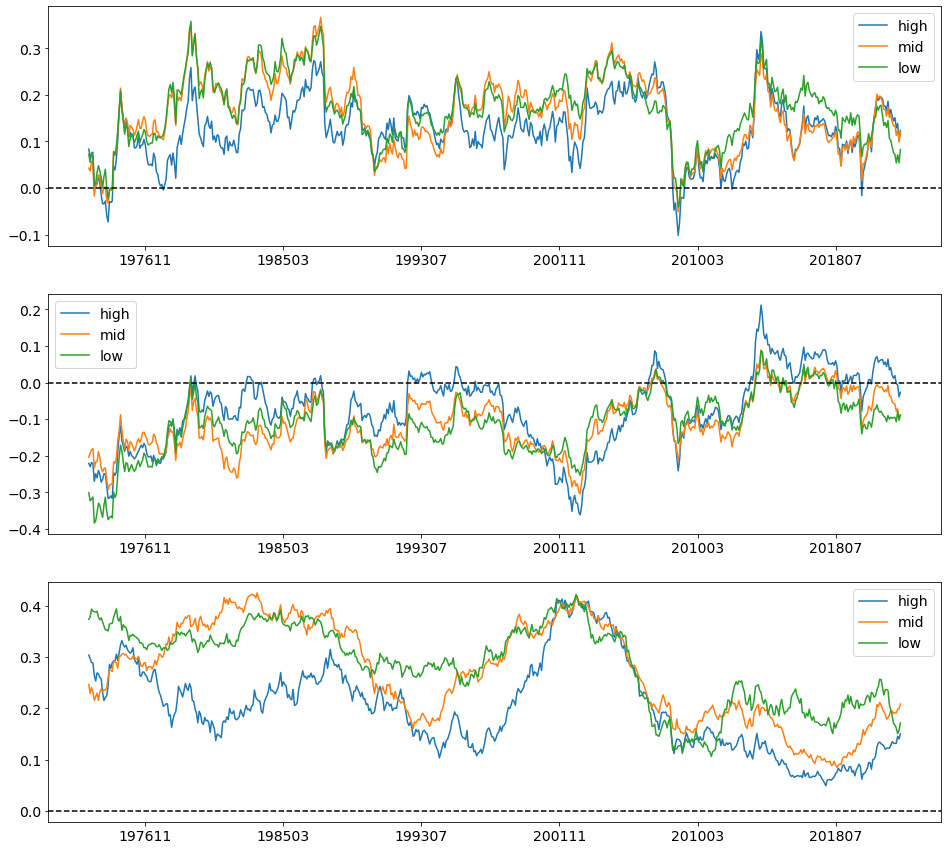

In [66]:
fig, axs = plt.subplots(3, figsize=(16, 15))
(long_returns.rolling(60).mean() * 12).plot(ax=axs[0])
(short_returns.rolling(60).mean() * 12).plot(ax=axs[1])
((long_returns - short_returns).rolling(60).mean() * 12).plot(ax=axs[2])
axs[0].axhline(0, ls='--', color='black')
axs[1].axhline(0, ls='--', color='black')
axs[2].axhline(0, ls='--', color='black')

<AxesSubplot:>

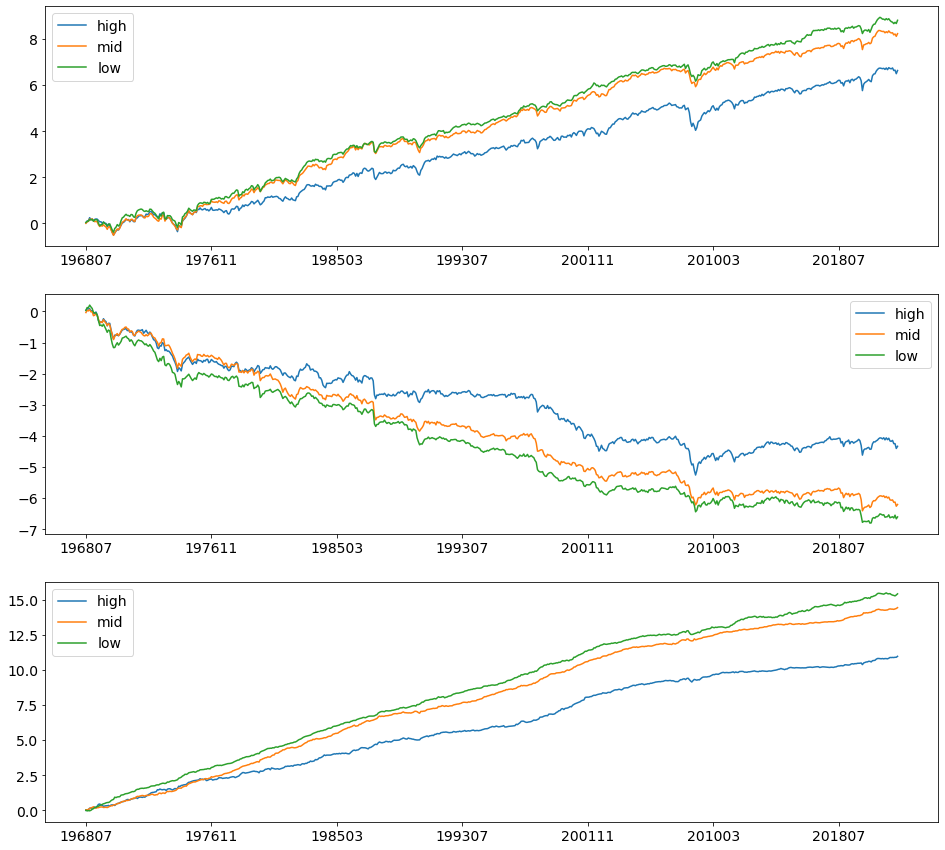

In [67]:
fig, axs = plt.subplots(3, figsize=(16, 15))
long_returns.cumsum().plot(ax=axs[0])
short_returns.cumsum().plot(ax=axs[1])
(long_returns - short_returns).cumsum().plot(ax=axs[2])

In [68]:
configuration_returns = (long_returns - short_returns).fillna(0)
configuration_returns = 2 ** configuration_returns - 1
# configuration_returns_year = configuration_returns.copy()
configuration_returns_year = np.log(1 + configuration_returns.copy())
configuration_returns_year['year'] = pd.to_datetime(configuration_returns.index.str[:4] + '-' + configuration_returns.index.str[4:6] + '-' + configuration_returns.index.str[-2:]).year
melt_configuration_returns_year = configuration_returns_year.melt('year')
melt_configuration_returns_year['value'] *= 12
# melt_configuration_returns_year['value'] = ((1 + melt_configuration_returns_year['value']) ** 12 - 1) * 100
melt_configuration_returns_year

,year,variable,value
0,1968,high,-0.028326
1,1968,high,0.176909
2,1968,high,0.204582
3,1968,high,0.971664
4,1968,high,-0.099669
...,...,...,...
1939,2022,low,-0.308274
1940,2022,low,-0.198175
1941,2022,low,-0.266670
1942,2022,low,0.533275


In [103]:
melted_results = configuration_returns.reset_index().melt('index').rename(columns={'index': 'Date', 'variable': 'Liquidity'})

bs_expected_returns = bootstrap_dataset(melted_results, id_vars='Liquidity', 
    value_var='value', func=np.mean, n=5000)

bs_expected_sharpe = bootstrap_dataset(melted_results, id_vars='Liquidity', 
    value_var='value', func=sharpe, n=5000)

bs_expected_sortino = bootstrap_dataset(melted_results, id_vars='Liquidity', 
    value_var='value', func=sortino_ratio, n=5000)

In [110]:
summary = summary_table(bs_expected_returns, 
                        bs_expected_sharpe, 
                        bs_expected_sortino, 
                        group_col='Liquidity', index_names=['Liquidity'])

\begin{table}
\centering
\caption{This is the caption}
\begin{tabular}{llllllll}
\toprule
{} & Excess Returns & Sharpe Ratio & Sortino Ratio &   \  &               \   &          \    &         \     \\
\textbf{Liquidity} &                &              &               &      &                   &               &               \\
\midrule
\textbf{high     } &         1.22\% &         1.55 &          2.93 &  \\  &   (1.01\%-1.43\%) &   (1.29-1.82) &   (2.24-3.73) \\
\textbf{low      } &         1.69\% &         2.39 &          4.12 &  \\  &   (1.51\%-1.88\%) &   (2.07-2.69) &   (3.07-5.54) \\
\textbf{mid      } &         1.58\% &         2.51 &          5.32 &  \\  &   (1.42\%-1.75\%) &   (2.24-2.79) &     (4.2-6.8) \\
\bottomrule
\end{tabular}
\end{table}



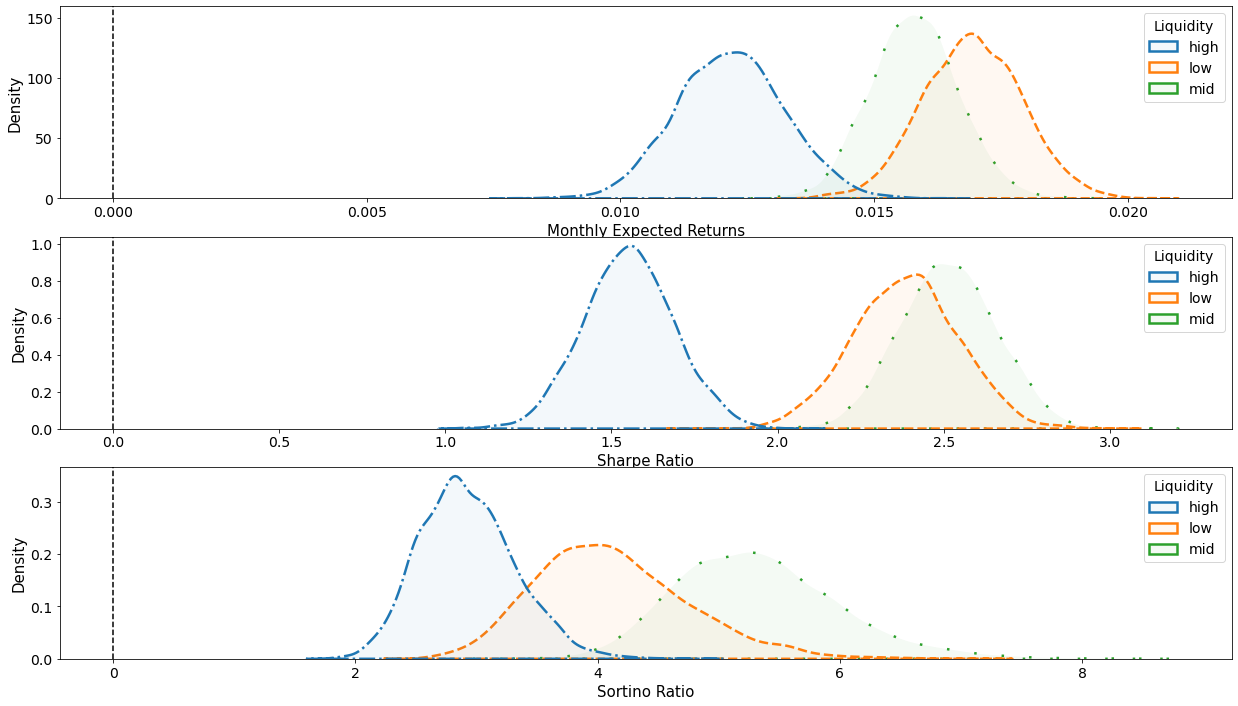

In [104]:
fig, axs = plt.subplots(3, figsize=(21, 12))

sns.kdeplot(data=bs_expected_returns, 
            x='value', fill=True, alpha=.05, palette='tab10',
            hue='Liquidity', linewidth=2.5, ax=axs[0])
axs[0].set_xlabel('Monthly Expected Returns')

sns.kdeplot(data=bs_expected_sharpe, 
            x='value', fill=True, alpha=.05, palette='tab10',
            hue='Liquidity', linewidth=2.5, ax=axs[1])
axs[1].set_xlabel('Sharpe Ratio')

sns.kdeplot(data=bs_expected_sortino, 
            x='value', fill=True, alpha=.05, palette='tab10',
            hue='Liquidity', linewidth=2.5, ax=axs[2])
axs[2].set_xlabel('Sortino Ratio')

if flag_ls:
    for ax in axs:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(0, ls='--', color='black')
else:
    for ax in axs:
        ax.axvline(0, ls='--', color='black')
        
plt.savefig('img/market_cap_results.pdf')
plt.show()

In [69]:
def sharpe(x):
    return x.mean() / (x.std() + 1e-6) * np.sqrt(12)

def sortino_ratio(x):
    mean = x.mean()
    if (x<0).sum() > 10:
        std_neg = x[x<0].std()
    else:
        std_neg = x.std()
    return mean / std_neg * np.sqrt(12)

def bootstrap_dataset(data, id_vars, value_var, func, n=500):
    enclosure_flag = (type(id_vars) != list) or (len(id_vars) == 1)
    if type(id_vars) != list:
        id_vars = [id_vars]
    bs_dfs = []
    for conf, group_df in data.groupby(id_vars):
        values = group_df[value_var].values
        values_size = values.size
        boot = [func(values[np.random.randint(values_size, size=values_size)]) for it in range(n)]
        if enclosure_flag: 
            conf = [conf]
        data_dict = dict(zip(id_vars, conf))
        data_dict[value_var] = boot
        
        bs_dfs.append(pd.DataFrame(data_dict))
    return pd.concat(bs_dfs)

In [70]:
melt_configuration_returns_year['year_5'] = (melt_configuration_returns_year['year'] // 5 * 5)
melt_configuration_returns_year['year_2'] = (melt_configuration_returns_year['year'] // 2 * 2)

In [71]:
bs_expected_returns = bootstrap_dataset(melt_configuration_returns_year, 
    id_vars=['year_2', 'variable'], 
    value_var='value', func=np.mean, n=500)
bs_expected_returns['value'] = (np.exp(bs_expected_returns['value']) - 1) * 100

In [72]:
bs_expected_returns

,year_2,variable,value
0,1968,high,15.125762
1,1968,high,20.567951
2,1968,high,19.006629
3,1968,high,15.861678
4,1968,high,22.393032
...,...,...,...
495,2022,mid,-4.458155
496,2022,mid,13.481910
497,2022,mid,1.309080
498,2022,mid,22.797054


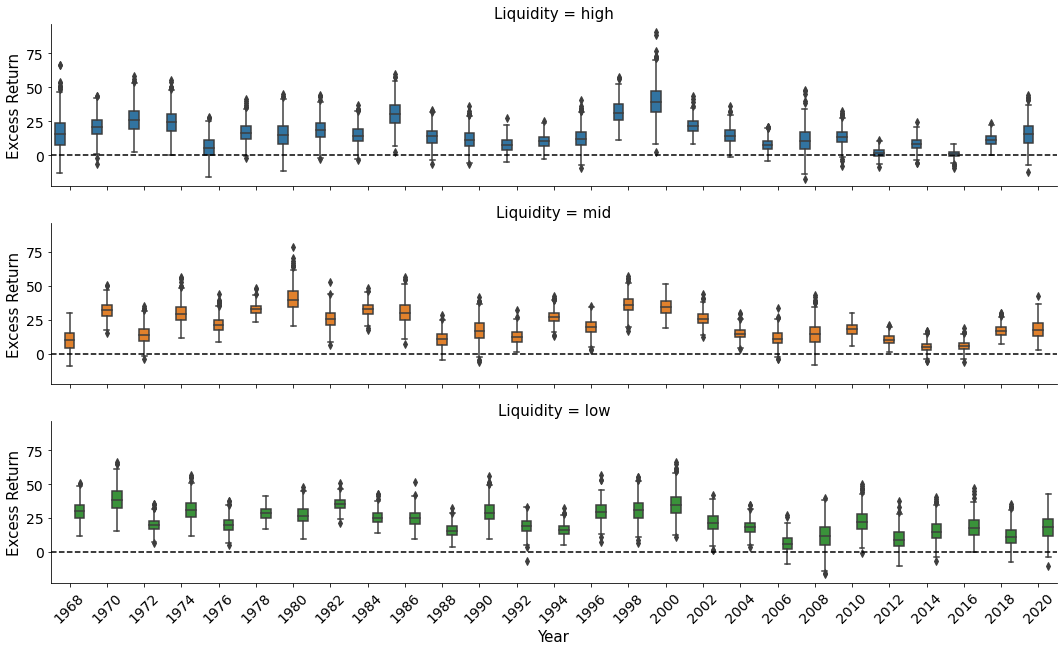

In [73]:
g = sns.catplot(data=bs_expected_returns.rename(columns={'variable': 'Liquidity'})[(bs_expected_returns['year_2'] <= 2021)], 
                x='year_2', y='value', 
                row='Liquidity', hue='Liquidity', height=3, aspect=5, kind="box",
                row_order=['high', 'mid', 'low'], hue_order=['high', 'mid', 'low'])
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='black')
    ax.set_ylabel('Excess Return')
    
plt.xlabel('Year')
plt.xticks(rotation = 45) 

plt.savefig('img/market_cap_excess_return_overtime.pdf')

plt.show()

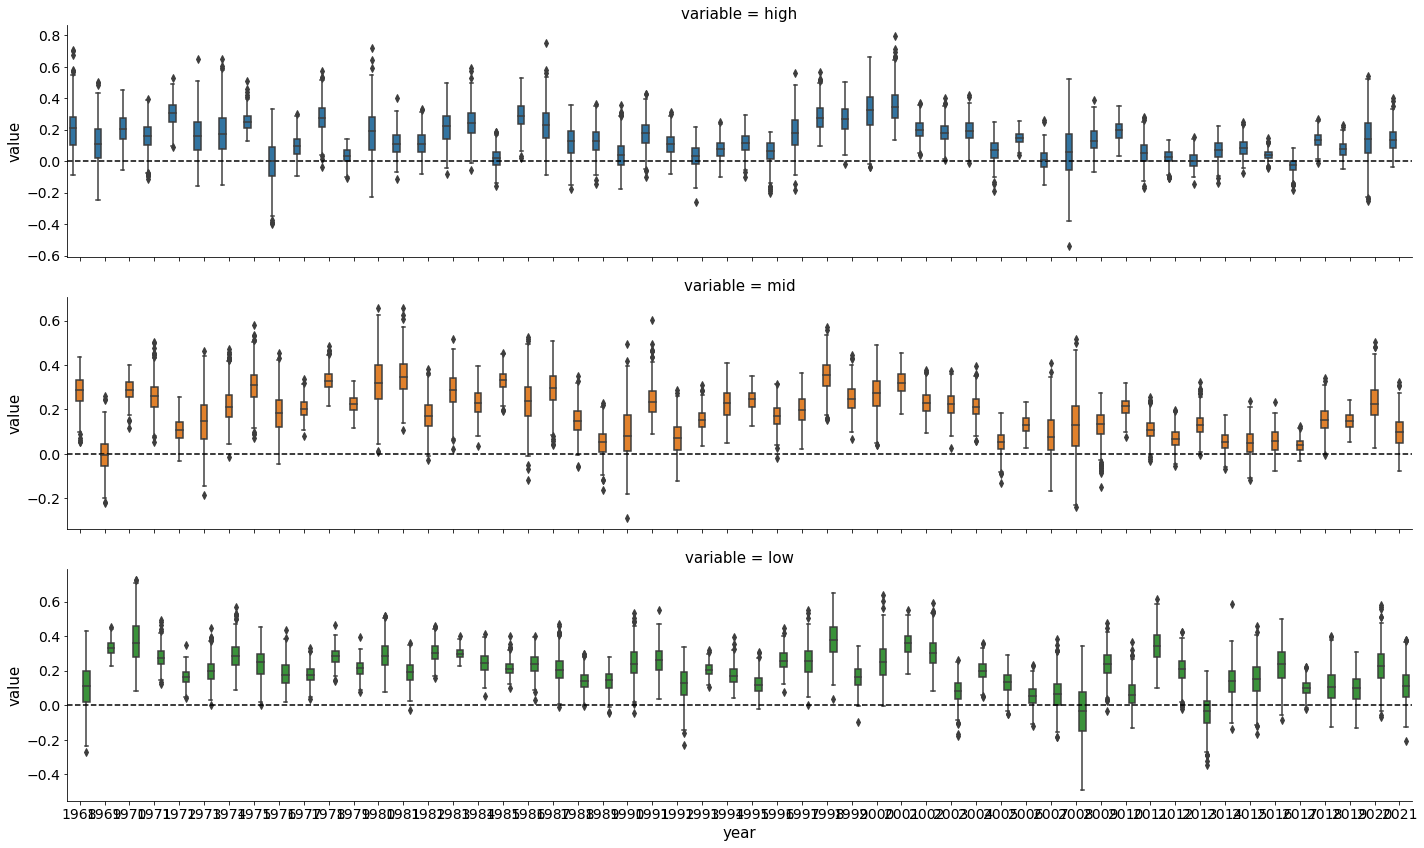

In [74]:
#configuration_returns_year
bs_expected_returns_year_spreads = bootstrap_dataset(melt_configuration_returns_year[(melt_configuration_returns_year['year'] <= 2021)], 
                                                     id_vars=['year', 'variable'], value_var='value', func=np.mean, n=500)

g = sns.catplot(data=bs_expected_returns_year_spreads, x='year', y='value', 
                row='variable', hue='variable', height=4, aspect=5, kind="box", sharey=False,
                row_order=['high', 'mid', 'low'], hue_order=['high', 'mid', 'low'])
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='black')

## 5-Factors

In [90]:
factors = pd.read_csv("data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=2)
factors = factors[factors['Date'].astype(str).str.strip().str.len() == 6]
factors = factors.set_index('Date')
factors = factors.astype(np.float64)
factors['alpha'] = 1.
factors

,Mkt-RF,SMB,HML,RMW,CMA,RF,alpha
Date,,,,,,,
196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27,1.0
196308,5.07,-0.80,1.80,0.36,-0.35,0.25,1.0
196309,-1.57,-0.52,0.13,-0.71,0.29,0.27,1.0
196310,2.53,-1.39,-0.10,2.80,-2.01,0.29,1.0
196311,-0.85,-0.88,1.75,-0.51,2.24,0.27,1.0
...,...,...,...,...,...,...,...
202205,-0.34,-0.06,8.41,1.44,3.98,0.03,1.0
202206,-8.43,1.30,-5.97,1.85,-4.70,0.06,1.0
202207,9.57,1.88,-4.10,0.68,-6.94,0.08,1.0


In [91]:
coefs = []
pvals = []
lows = []
ups = []

for col in configuration_returns.columns:
    config_ret = configuration_returns[col] * 100
    model = sm.OLS(config_ret, factors.loc[config_ret.index])
    results = model.fit()
    
    ols_results_df = pd.DataFrame(results.summary().tables[1].data).set_index(0)
    ols_results_df.columns = ols_results_df.iloc[0]
    ols_results_df = ols_results_df.iloc[1:].astype('float')
    ols_results_coef = ols_results_df['coef']
    ols_results_pval = ols_results_df['P>|t|']
    ols_results_low = ols_results_df['[0.025']
    ols_results_up = ols_results_df['0.975]']
    
    coefs.append(ols_results_coef)
    pvals.append(ols_results_pval)
    lows.append(ols_results_low)
    ups.append(ols_results_up)
    
coefs_df = pd.DataFrame(coefs, index=configuration_returns.columns).round(3)
pvals_df = pd.DataFrame(pvals, index=configuration_returns.columns).round(2)
lows_df = pd.DataFrame(lows, index=configuration_returns.columns).round(2)
ups_df = pd.DataFrame(ups, index=configuration_returns.columns).round(3)

KeyError: "None of [DatetimeIndex(['1968-07-01', '1968-08-01', '1968-09-01', '1968-10-01',\n               '1968-11-01', '1968-12-01', '1969-01-01', '1969-02-01',\n               '1969-03-01', '1969-04-01',\n               ...\n               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',\n               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',\n               '2022-05-01', '2022-06-01'],\n              dtype='datetime64[ns]', length=648, freq=None)] are in the [index]"

In [77]:
coefs_df.style.highlight_max()

0,Mkt-RF,SMB,HML,RMW,CMA,RF
high,0.033000,0.001000,-0.038000,0.029000,0.131000,2.216000
mid,0.038000,0.001000,-0.061000,0.083000,0.129000,3.110000
low,-0.017000,-0.006000,-0.069000,0.085000,0.098000,3.261000


In [78]:
coef_stat = ('$' + coefs_df.astype(str) + 
 np.vectorize(lambda x: '^{*}' * x)(((pvals_df > 0.01) & (pvals_df <= 0.05)).astype(int)) +
 np.vectorize(lambda x: '^{**}' * x)(((pvals_df > 0.001) & (pvals_df <= 0.01)).astype(int)) +
 np.vectorize(lambda x: '^{***}' * x)((pvals_df <= 0.001).astype(int)) +
 '$').reset_index()
# coef_stat['Configuration'] = coef_stat['spreads_method'].str.split(expand=True)[0] + ' ' + coef_stat['trading_method'].str[13:]

coef_stat['\ '] = '\\\\ &'
coef_stat

,index,Mkt-RF,SMB,HML,RMW,CMA,RF,\
0,high,$0.033$,$0.001$,$-0.038$,$0.029$,$0.131$,$2.216^{***}$,\\ &
1,mid,$0.038$,$0.001$,$-0.061$,$0.083^{*}$,$0.129^{*}$,$3.11^{***}$,\\ &
2,low,$-0.017$,$-0.006$,$-0.069$,$0.085$,$0.098$,$3.261^{***}$,\\ &


In [79]:
ci_df = ('(' + lows_df.astype(str) + ', ' + ups_df.astype(str) +')').reset_index(drop=True)
ci_df.columns= ['\  ', '\   ', '\    ', '\     ', '\      ', '\       ', '\        ']
ci_df

,\,\,\,\,\,\
0,"(-0.02, 0.085)","(-0.08, 0.08)","(-0.14, 0.061)","(-0.07, 0.133)","(-0.02, 0.286)","(1.74, 2.695)"
1,"(-0.0, 0.08)","(-0.06, 0.064)","(-0.14, 0.018)","(-0.0, 0.167)","(0.0, 0.255)","(2.72, 3.497)"
2,"(-0.06, 0.031)","(-0.08, 0.067)","(-0.16, 0.022)","(-0.01, 0.181)","(-0.04, 0.241)","(2.82, 3.703)"


In [80]:
print(pd.concat([coef_stat, ci_df], axis=1).to_latex(bold_rows=True,
                       caption='This is the caption',
                       escape=False,
                      ))

\begin{table}
\centering
\caption{This is the caption}
\begin{tabular}{lllllllllllllll}
\toprule
{} & index &    Mkt-RF &       SMB &       HML &          RMW &          CMA &             RF &    \  &             \   &            \    &           \     &          \      &         \       &       \        \\
\midrule
\textbf{0} &  high &   $0.033$ &   $0.001$ &  $-0.038$ &      $0.029$ &      $0.131$ &  $2.216^{***}$ &  \\ & &  (-0.02, 0.085) &   (-0.08, 0.08) &  (-0.14, 0.061) &  (-0.07, 0.133) &  (-0.02, 0.286) &  (1.74, 2.695) \\
\textbf{1} &   mid &   $0.038$ &   $0.001$ &  $-0.061$ &  $0.083^{*}$ &  $0.129^{*}$ &   $3.11^{***}$ &  \\ & &    (-0.0, 0.08) &  (-0.06, 0.064) &  (-0.14, 0.018) &   (-0.0, 0.167) &    (0.0, 0.255) &  (2.72, 3.497) \\
\textbf{2} &   low &  $-0.017$ &  $-0.006$ &  $-0.069$ &      $0.085$ &      $0.098$ &  $3.261^{***}$ &  \\ & &  (-0.06, 0.031) &  (-0.08, 0.067) &  (-0.16, 0.022) &  (-0.01, 0.181) &  (-0.04, 0.241) &  (2.82, 3.703) \\
\bottomrule
\end{tabul

In [81]:
factors_alpha = factors.copy()
factors_alpha['alpha'] = 1.
results_returns_lm = LinearRegression(fit_intercept=True).fit(factors_alpha.loc[configuration_returns.index].drop(columns='alpha'), configuration_returns)
results_alphas = pd.Series(results_returns_lm.intercept_ * 12, index=configuration_returns.columns, name='alpha').sort_values(ascending=False)
results_alphas = results_alphas.reset_index()#.drop(columns='level_0')
results_alphas

,index,alpha
0,low,0.163242
1,mid,0.128569
2,high,0.120076


In [82]:
configuration_returns.index = pd.to_datetime(configuration_returns.index + '01')

In [83]:
import arch

In [84]:
sp500_index_returns = pd.read_csv('data/sp500_returns.csv', parse_dates=['Date'])
returns = sp500_index_returns.set_index('Date').loc[configuration_returns.index]
am = arch.arch_model(returns * 100, vol="Garch", p=1, o=0, q=1, dist="Normal")
forecasts = {}
for i in range(len(returns)- 60):
    res = am.fit(first_obs=i, last_obs=i + 60, disp="off")
    temp = res.forecast(horizon=1, reindex=False).variance
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast
    
garch_vol = pd.DataFrame(forecasts).T.reset_index().rename(columns={'h.1': 'Garch Vol.', 
                                                                    'index': 'Date'})
garch_vol

,Date,Garch Vol.
0,1973-06-01,10.454173
1,1973-07-01,10.819087
2,1973-08-01,11.374390
3,1973-09-01,8.650010
4,1973-10-01,21.626024
...,...,...
583,2022-01-01,21.288429
584,2022-02-01,15.025741
585,2022-03-01,47.337004
586,2022-04-01,17.105722


In [85]:
factors.index = pd.to_datetime(factors.index + '01')
factors['alpha'] = 1.

In [86]:
rolling_alpha_df = pd.DataFrame({col: RollingOLS(configuration_returns[col] * 100, factors.loc[configuration_returns.index], window=60).fit().params['alpha'] for col in configuration_returns.columns},
                                index=configuration_returns.index).dropna().reset_index().rename(columns={'index':'date'})

rolling_alpha_pval_df = pd.DataFrame({col: RollingOLS(configuration_returns[col] * 100, factors.loc[configuration_returns.index], window=60).fit().pvalues[:, -1] for col in configuration_returns.columns},
             index=configuration_returns.index).dropna().reset_index().rename(columns={'index':'date'})

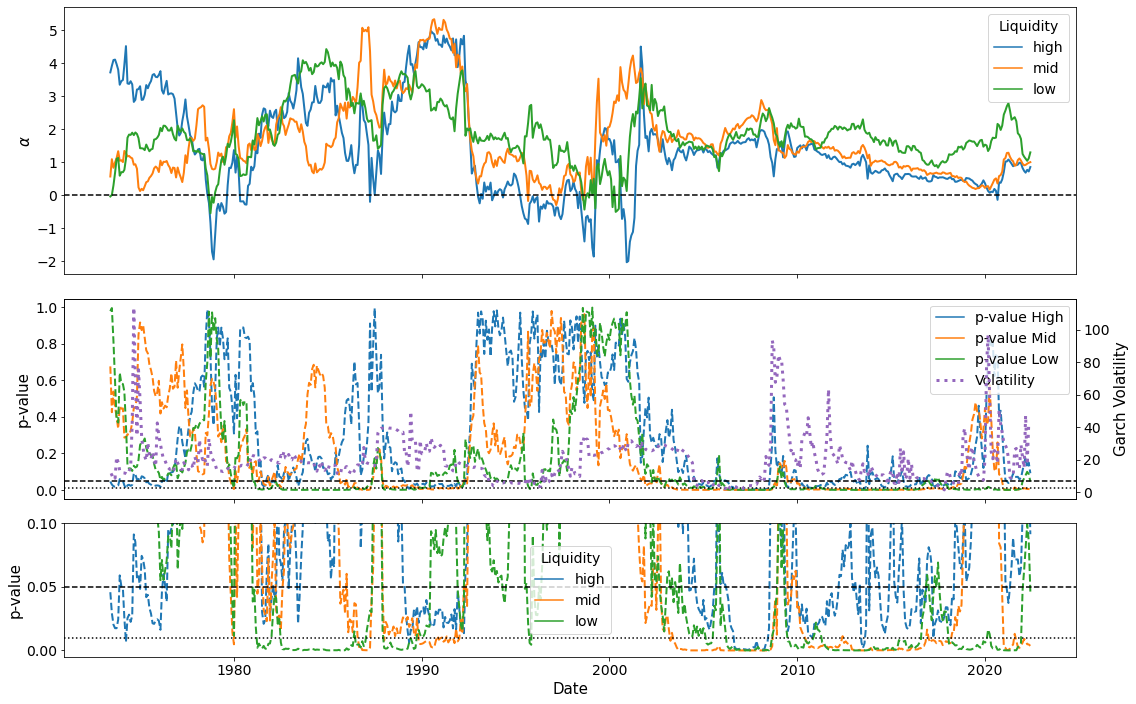

In [87]:
fig, [ax, ax2, ax_small] = plt.subplots(3, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [2, 1.5, 1]})

sns.lineplot(data=rolling_alpha_df.melt('date').rename(columns={'variable': 'Liquidity'}),
             x='date', y='value', hue='Liquidity', ax=ax, lw=2)
ax.axhline(0, ls='--', color='black')
ax.set_ylabel('$\\alpha$')

sns.lineplot(data=rolling_alpha_pval_df.melt('date').rename(columns={'variable': 'Liquidity'}),
             x='date', y='value', hue='Liquidity', ax=ax2, ls='--', lw=2)
ax2.axhline(.05, ls='--', color='black')
ax2.axhline(.01, ls=':', color='black')
ax2.set_ylabel('p-value')

sns.lineplot(data=rolling_alpha_pval_df.melt('date').rename(columns={'variable': 'Liquidity'}),
             x='date', y='value', hue='Liquidity', ax=ax_small, ls='--', legend=True, lw=2)
ax_small.axhline(.05, ls='--', color='black')
ax_small.axhline(.01, ls=':', color='black')
ax_small.set_ylim(-.005, .1)
ax_small.set_ylabel('p-value')

ax3 = ax2.twinx()
# ax3.spines['right'].set_position(('outward', 70))

sns.lineplot(data=garch_vol, lw=3,
             x='Date', y='Garch Vol.', ax=ax3, ls=':', c='tab:purple', label='vol', legend=False)
ax3.set_ylabel('Garch Volatility')


ax2.legend(ax2.get_legend_handles_labels()[0] + ax3.get_legend_handles_labels()[0],
           ['p-value High', 'p-value Mid', 'p-value Low ', 'Volatility'])

ax.tick_params(labelbottom=False)
ax.set_xlabel('')

ax2.tick_params(labelbottom=False)
ax2.set_xlabel('')
ax_small.set_xlabel('Date')


fig.tight_layout()
plt.savefig('img/market_cap_alpha_overtime.pdf')

plt.show()

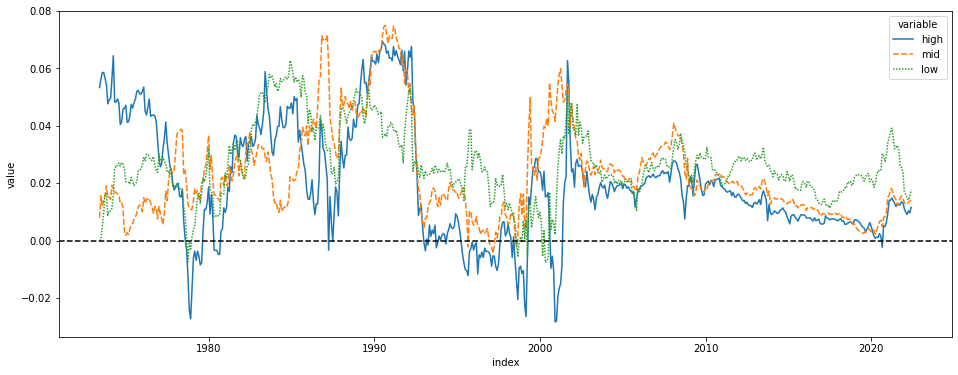

In [23]:
rolling_alpha_df = pd.DataFrame({col: RollingOLS(configuration_returns[col], factors_alpha.loc[configuration_returns.index], window=60).fit().params['alpha'] for col in configuration_returns.columns},
                                index=configuration_returns.index)#['avg_month_returns']['residuals'].dropna() * 12
rolling_alpha_df.index = pd.to_datetime(rolling_alpha_df.index.str[:-2] + '-' + rolling_alpha_df.index.str[-2:] + '-01')

fig, ax = plt.subplots(figsize=(16, 6))
# rolling_alpha_df.plot(ax=ax)
sns.lineplot(data=rolling_alpha_df.reset_index().melt('index'),
             x='index', y='value', hue='variable', style='variable', ax=ax)
ax.axhline(0, ls='--', color='black')
plt.show()

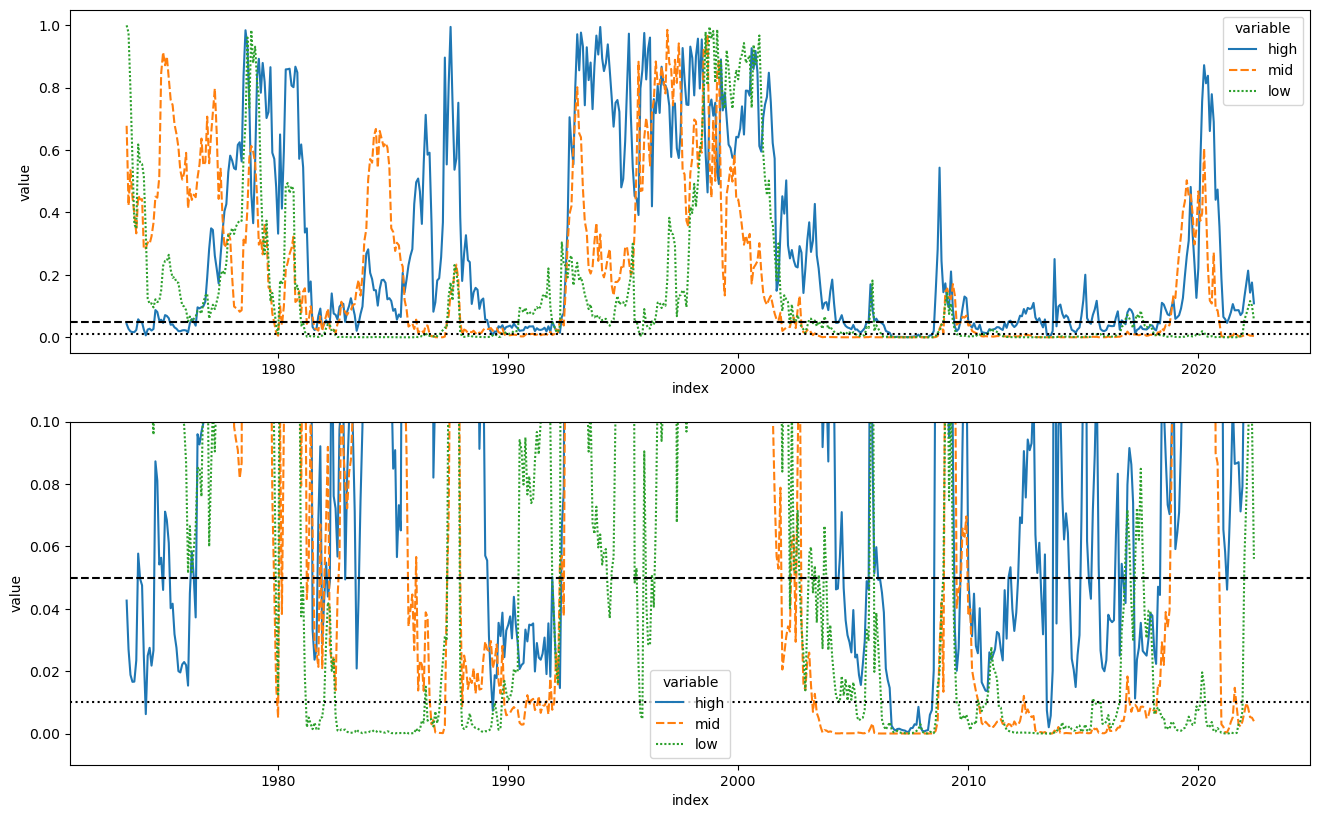

In [24]:
rolling_alpha_pval_df = pd.DataFrame({col: RollingOLS(configuration_returns[col], factors_alpha.loc[configuration_returns.index], window=60).fit().pvalues[:, -1] for col in configuration_returns.columns},
             index=configuration_returns.index)
rolling_alpha_pval_df.index = pd.to_datetime(rolling_alpha_pval_df.index.str[:-2] + '-' + rolling_alpha_pval_df.index.str[-2:] + '-01')
fig, axs = plt.subplots(2, figsize=(16, 10), dpi=100)
# rolling_alpha_pval_df.plot(ax=ax)
sns.lineplot(data=rolling_alpha_pval_df.reset_index().melt('index'),
             x='index', y='value', hue='variable', style='variable', ax=axs[0])
axs[0].axhline(.05, ls='--', color='black')
axs[0].axhline(.01, ls=':', color='black')

sns.lineplot(data=rolling_alpha_pval_df.reset_index().melt('index'),
             x='index', y='value', hue='variable', style='variable', ax=axs[1])
axs[1].axhline(.05, ls='--', color='black')
axs[1].axhline(.01, ls=':', color='black')
axs[1].set_ylim(-.01, .1)
plt.show()

In [88]:
freq_sign_alpha = pd.concat([(rolling_alpha_pval_df.set_index('date').dropna() < .05).mean(), 
           (rolling_alpha_pval_df.set_index('date').dropna() < .01).mean(), 
           (rolling_alpha_pval_df.set_index('date').dropna() < .001).mean()], axis=1)
freq_sign_alpha.columns = ['$\\alpha-pval < 0.05$','$\\alpha-pval < 0.01$','$\\alpha-pval < 0.001$']
freq_sign_alpha = (freq_sign_alpha * 100).round(1).astype(str) + '\%'

In [89]:
print(freq_sign_alpha.to_latex(bold_rows=True,
                       caption='This is the caption',
                       escape=False,
                      ))

\begin{table}
\centering
\caption{This is the caption}
\begin{tabular}{llll}
\toprule
{} & $\alpha-pval < 0.05$ & $\alpha-pval < 0.01$ & $\alpha-pval < 0.001$ \\
\midrule
\textbf{high} &               32.9\% &                4.8\% &                 1.5\% \\
\textbf{mid } &               50.3\% &               35.1\% &                17.1\% \\
\textbf{low } &               58.6\% &               41.8\% &                19.0\% \\
\bottomrule
\end{tabular}
\end{table}

